In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
import joblib



# -------------------
# 1. Chargement des données et nettoyage
# -------------------


In [57]:
# Charger les données depuis le fichier CSV (veiller à préciser le type de chaque colonne pour optimiser la mémoire)
file_path = 'laptop_data.csv'
laptop_data = pd.read_csv(file_path, dtype={'Ram': 'str', 'Weight': 'str', 'Price': 'float64'})

# Afficher un aperçu des premières lignes pour mieux comprendre la structure du dataset
laptop_head = laptop_data.head()
laptop_info = laptop_data.info()
laptop_description = laptop_data.describe(include='all')

print(laptop_head)
print(laptop_info)
print(laptop_description)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   TypeName          1303 non-null   object 
 3   Inches            1303 non-null   float64
 4   ScreenResolution  1303 non-null   object 
 5   Cpu               1303 non-null   object 
 6   Ram               1303 non-null   object 
 7   Memory            1303 non-null   object 
 8   Gpu               1303 non-null   object 
 9   OpSys             1303 non-null   object 
 10  Weight            1303 non-null   object 
 11  Price             1303 non-null   float64
dtypes: float64(2), int64(1), object(9)
memory usage: 122.3+ KB
   Unnamed: 0 Company   TypeName  Inches                    ScreenResolution  \
0           0   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   
1          

In [58]:
# Nettoyage des données

# Supprimer la colonne inutile "Unnamed: 0" qui est souvent une colonne d'index
laptop_data_cleaned = laptop_data.drop(columns=["Unnamed: 0"])

# Convertir les colonnes 'Ram' et 'Weight' en types numériques pour une meilleure manipulation
laptop_data_cleaned['Ram'] = laptop_data_cleaned['Ram'].str.replace('GB', '').astype(int)  # Enlever 'GB' et convertir en entier
laptop_data_cleaned['Weight'] = laptop_data_cleaned['Weight'].str.replace('kg', '').astype(float)  # Enlever 'kg' et convertir en flottant

# Extraire les informations de résolution d'écran (Width et Height) à partir de 'ScreenResolution'
screen_res_split = laptop_data_cleaned['ScreenResolution'].str.extract(r'(?P<Width>\d+)x(?P<Height>\d+)')
laptop_data_cleaned['Width'] = screen_res_split['Width'].astype(float)
laptop_data_cleaned['Height'] = screen_res_split['Height'].astype(float)

# Vérification des modifications
print(laptop_data_cleaned.head())

  Company   TypeName  Inches                    ScreenResolution  \
0   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   
1   Apple  Ultrabook    13.3                            1440x900   
2      HP   Notebook    15.6                   Full HD 1920x1080   
3   Apple  Ultrabook    15.4  IPS Panel Retina Display 2880x1800   
4   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   

                          Cpu  Ram               Memory  \
0        Intel Core i5 2.3GHz    8            128GB SSD   
1        Intel Core i5 1.8GHz    8  128GB Flash Storage   
2  Intel Core i5 7200U 2.5GHz    8            256GB SSD   
3        Intel Core i7 2.7GHz   16            512GB SSD   
4        Intel Core i5 3.1GHz    8            256GB SSD   

                            Gpu  OpSys  Weight        Price   Width  Height  
0  Intel Iris Plus Graphics 640  macOS    1.37   71378.6832  2560.0  1600.0  
1        Intel HD Graphics 6000  macOS    1.34   47895.5232  1440.0   900.0  
2 

# -------------------
# 2. Visualisation des données
# -------------------

/home/gblack98/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/gblack98/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/gblack98/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


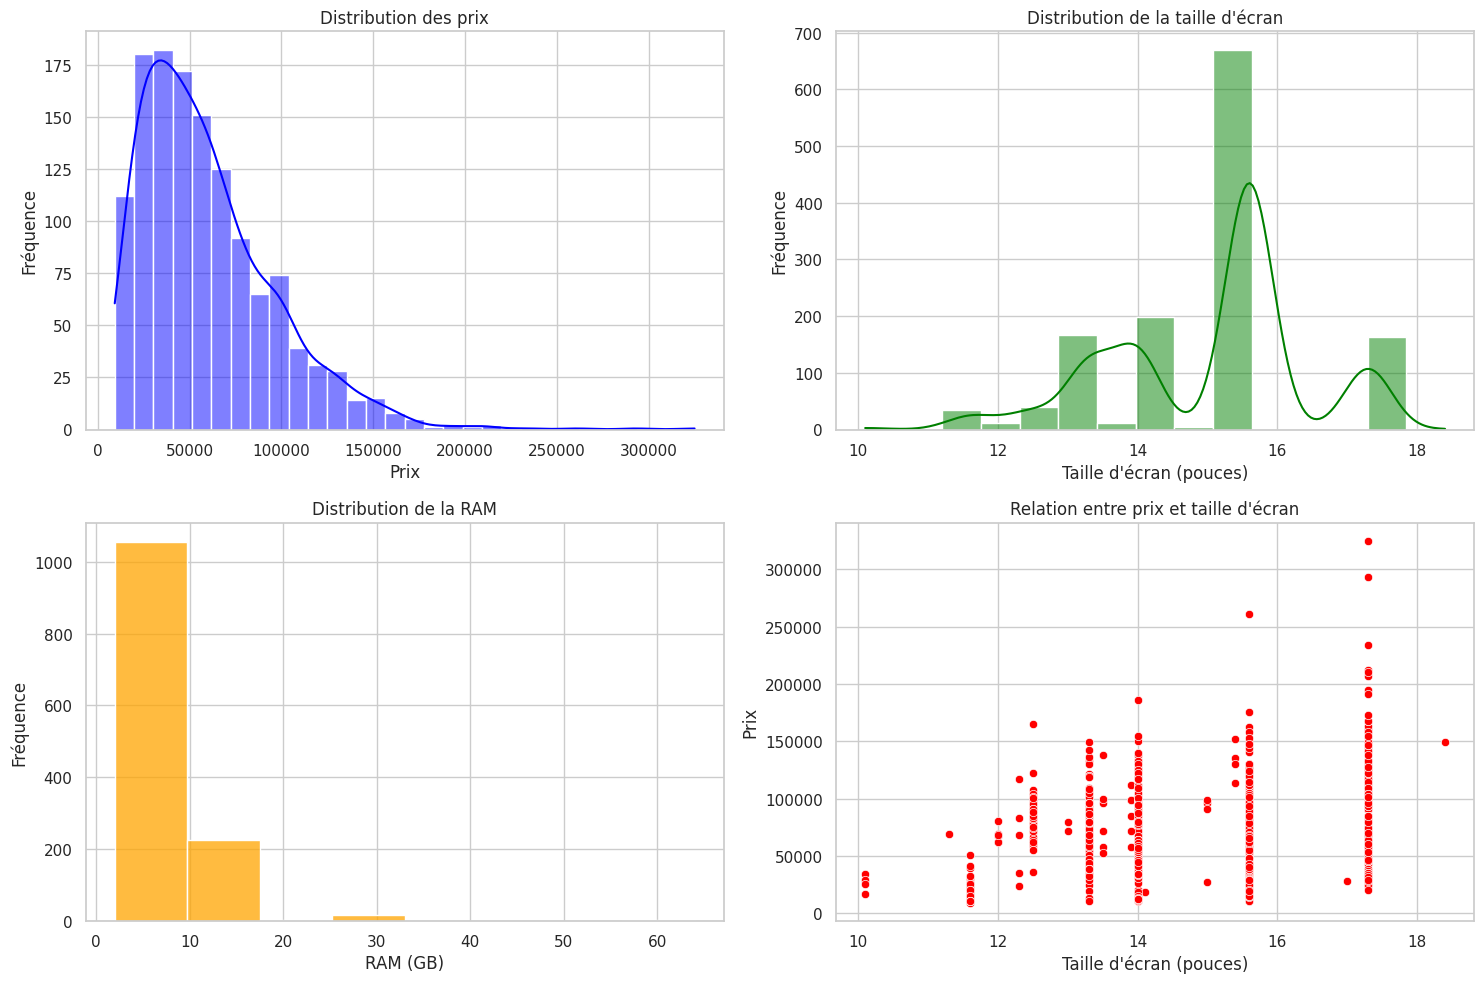

In [70]:
# Configuration de base des graphiques
sns.set(style="whitegrid")

# Création de sous-graphiques pour analyser les distributions des données importantes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution des prix
sns.histplot(laptop_data_cleaned['Price'], bins=30, kde=True, ax=axes[0, 0], color='blue')
axes[0, 0].set_title("Distribution des prix")
axes[0, 0].set_xlabel("Prix")
axes[0, 0].set_ylabel("Fréquence")

# Distribution de la taille d'écran
sns.histplot(laptop_data_cleaned['Inches'], bins=15, kde=True, ax=axes[0, 1], color='green')
axes[0, 1].set_title("Distribution de la taille d'écran")
axes[0, 1].set_xlabel("Taille d'écran (pouces)")
axes[0, 1].set_ylabel("Fréquence")

# Distribution de la RAM
sns.histplot(laptop_data_cleaned['Ram'], bins=8, kde=False, ax=axes[1, 0], color='orange')
axes[1, 0].set_title("Distribution de la RAM")
axes[1, 0].set_xlabel("RAM (GB)")
axes[1, 0].set_ylabel("Fréquence")

# Relation entre prix et taille d'écran
sns.scatterplot(x=laptop_data_cleaned['Inches'], y=laptop_data_cleaned['Price'], ax=axes[1, 1], color='red')
axes[1, 1].set_title("Relation entre prix et taille d'écran")
axes[1, 1].set_xlabel("Taille d'écran (pouces)")
axes[1, 1].set_ylabel("Prix")

plt.tight_layout()
plt.show()


# -------------------
# 3. Matrice de corrélation
# -------------------

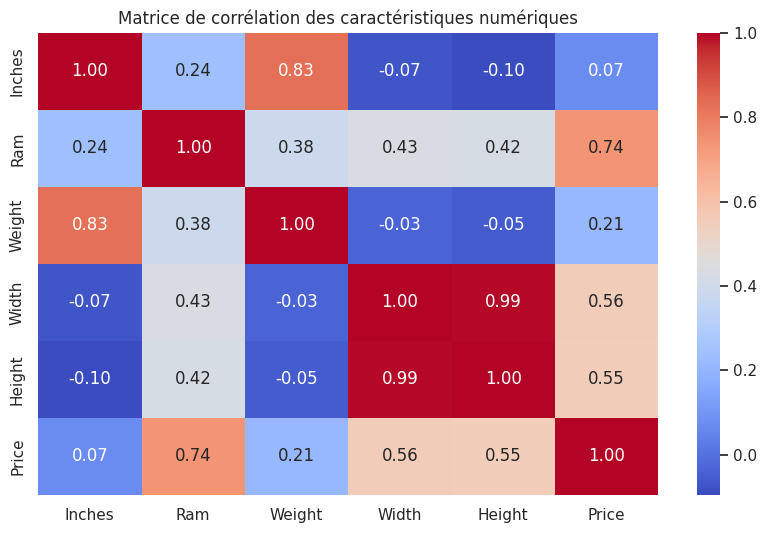

In [63]:
# Sélectionner les caractéristiques numériques pour calculer la matrice de corrélation
numeric_features = ['Inches', 'Ram', 'Weight', 'Width', 'Height', 'Price']
correlation_matrix = laptop_data_cleaned[numeric_features].corr()

# Visualisation de la matrice de corrélation
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation des caractéristiques numériques")
plt.show()


# -------------------
# 4. Séparation des données et préparation du modèle
# -------------------

In [ ]:


# Définir les caractéristiques (features) et la cible (target)
features = ['Company', 'TypeName', 'Inches', 'Ram', 'Weight', 'Width', 'Height', 'Cpu', 'Gpu', 'OpSys']
target = 'Price'

# Séparation des données en ensembles d'entraînement et de test
X = laptop_data_cleaned[features]
y = laptop_data_cleaned[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prétraitement des variables catégorielles avec OneHotEncoder
categorical_features = ['Company', 'TypeName', 'Cpu', 'Gpu', 'OpSys']
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  

# Prétraitement des variables numériques avec StandardScaler
numeric_features = ['Inches', 'Ram', 'Weight', 'Width', 'Height']
numeric_transformer = StandardScaler()

# Pipeline de prétraitement
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ]
)


# -------------------
## 5. Modélisation
# -------------------



# 5.1 Régression Linéaire

In [65]:
# Pipeline pour la régression linéaire
linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Entraînement du modèle
linear_pipeline.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred_linear = linear_pipeline.predict(X_test)

# Évaluation du modèle
mae_linear = mean_absolute_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
r2_linear = r2_score(y_test, y_pred_linear)

# 5.2 Random Forest

In [66]:
# Pipeline pour Random Forest
random_forest_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Entraînement du modèle
random_forest_pipeline.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred_rf = random_forest_pipeline.predict(X_test)

# Évaluation du modèle
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# Résumé des performances
performance_summary = {
    "Linear Regression": {"MAE": mae_linear, "RMSE": rmse_linear, "R²": r2_linear},
    "Random Forest": {"MAE": mae_rf, "RMSE": rmse_rf, "R²": r2_rf}
}

print(performance_summary)

{'Linear Regression': {'MAE': 39742522533106.04, 'RMSE': 236273273367531.9, 'R²': -3.871683707449518e+19}, 'Random Forest': {'MAE': 10623.562403339247, 'RMSE': 17662.066208546858, 'R²': 0.7836515980929751}}


# -------------------
# 6. Courbe d'apprentissage
# -------------------

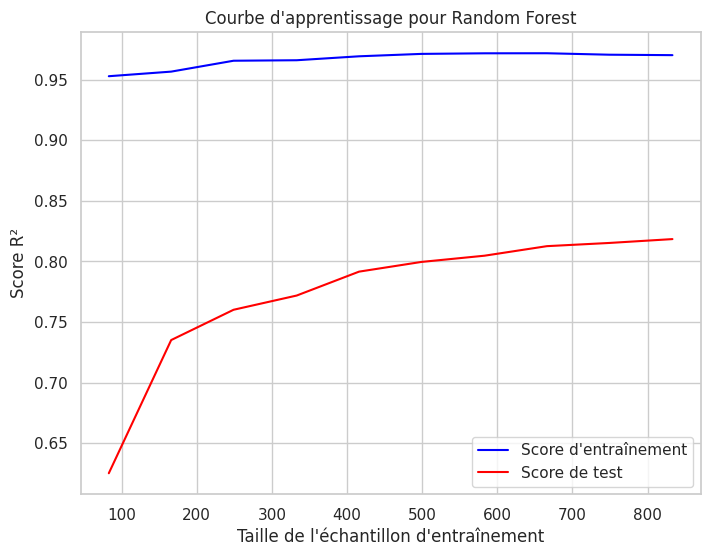

In [67]:
# Fonction pour tracer la courbe d'apprentissage
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label="Score d'entraînement", color="blue")
    plt.plot(train_sizes, test_mean, label="Score de test", color="red")
    plt.xlabel('Taille de l\'échantillon d\'entraînement')
    plt.ylabel('Score R²')
    plt.title('Courbe d\'apprentissage pour Random Forest')
    plt.legend()
    plt.grid(True)
    plt.show()

# Affichage de la courbe d'apprentissage pour Random Forest
plot_learning_curve(random_forest_pipeline, X_train, y_train)



In [68]:
# Sauvegarder le modèle avec joblib
joblib.dump(random_forest_pipeline, 'random_forest_pipeline_laptop_price_predictor_model.pkl')

print("Le modèle random_forest a été sauvegardé avec succès!")
# Sauvegarder le modèle avec joblib
joblib.dump(linear_pipeline, 'linear_pipeline_laptop_price_predictor_model.pkl')
print("Le modèle linear a été sauvegardé avec succès!")



Le modèle random_forest a été sauvegardé avec succès!
Le modèle linear a été sauvegardé avec succès!
